# Experimentos

Notebook com o propósito de compreender o porque de NONE UDLF Non-Local Means possuir métricas melhores que o Non-Local Means e melhores que UDLF Non-Local Means de outros métodos (como CPRR, LHRR e RL-RECOM).

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

import os
import sys

from nlmeans.nlmeans import nlmeans

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

# Function related imports
from nlmeans.fourier_center import fourier_center
from pyUDLF import run_calls as udlf
from pyUDLF.utils import inputType

## UDLF Non-Local Means function

Função alterada do UDLF Non-Local Means com o objetivo de armazenar dados relevantes para o entendimento do comportamento do programa.

In [69]:
def nlmeans_udlf(ima_nse, hW, hP, tau, sig, shape, udl_method, udl_params, n_w):
    # This is a simple implementation of NL means:
    #
    #   Buades, A. and Coll, B. and Morel, J.M.,
    #
    #   Computer Vision and Pattern Recognition, 2005. CVPR
    #
    # It uses UDLF to define distance between patches

    iterate_verify = 0
    DIFF = []
    DIFF_UDLF = []
    DIFF_PATCH = []
    DIFF_PATCH_UDLF = []
    WEIGHT = []
    WEIGHT_ID = []
    WEIGHT_UDLF = []
    WEIGHT_ID_UDLF = []
    SHIFT_IMG_NLM = None
    SHIFT_IMG_UDLF = None

    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Weight value and weight names matrices
    w_values = []
    w_names = []

    # Main loop
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue

            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            diff = (ima_nse - ima_nse[x_idx, y_idx])**2

            # DEBUG
            DIFF.append(diff[0, 0])
            if iterate_verify == 0:
                SHIFT_IMG_NLM = ima_nse[x_idx, y_idx]
                iterate_verify = 1

            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))
            
            # DEBUG
            DIFF_PATCH.append(diff[0, 0])

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)
            w_id = np.ravel_multi_index([x_idx, y_idx], (M, N))

            # Save the weight matrix and its identifiers
            w_values.append(w)
            w_names.append(w_id)

            # DEGUG
            WEIGHT.append(w[0, 0])
            WEIGHT_ID.append(w_id[0, 0])

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    w_values.append(np.zeros((M, N)) + np.exp(-2*sig**2/tau**2))
    w_names.append(np.arange(M * N).reshape(M, N))
    
    # DEBUG
    DIFF.append(0) # Diff between the original image and unshifted image is 0
    DIFF_PATCH.append(0) 
    WEIGHT.append((np.zeros((M, N)) + np.exp(-2*sig**2/tau**2))[0, 0])
    WEIGHT_ID.append((np.arange(M * N).reshape(M, N))[0, 0])

    # Transform the python lists of matrices into a 3D numpy array
    w_values = np.stack(w_values, axis=-1)
    w_names = np.stack(w_names, axis=-1).astype(int)
    NEIGHBOURHOOD_SIZE = w_values.shape[2]

    # Create the ranked list of weight matrices for udlf
    ranked_lists = np.zeros((M * N, NEIGHBOURHOOD_SIZE), dtype=int)
    for i in range(M):
        for j in range(N):
            rl = np.rec.fromarrays((w_names[i, j, :], w_values[i, j, :]),
                                   names=('names', 'values'))
            rl = rl[rl['values'].argsort()]
            ranked_lists[i * M + j, :] = np.copy(rl['names'])

    # Create the input file for the UDLF
    np.savetxt('input.txt', ranked_lists, fmt='%d', delimiter=' ', newline='\n')

    # Creation of the weight names list
    weight_names_list = np.reshape(np.arange(0, M * N, dtype=int), (M * N, 1))
    np.savetxt('list.txt', weight_names_list, fmt='%d', delimiter=' ', newline='\n')

    # UDLF configuration
    input_data = udlf_config(
        size_dataset = M*N,
        L = NEIGHBOURHOOD_SIZE,
        udl_method = udl_method,
        udl_params = udl_params
    )

    if not udl_method == 'NONE':
        # Run the UDLF framework to get a ranked list of weights
        udlf.run(input_data, get_output=True)
        new_ranked_lists = np.loadtxt('output.txt',
                                      dtype=int,
                                      delimiter=' ',
                                      usecols=range(ranked_lists.shape[1]))
    else:
        new_ranked_lists = ranked_lists
        
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    if n_w is None or n_w > NEIGHBOURHOOD_SIZE:
        n_w = new_ranked_lists.shape[1]

    iterate_verify = 0
    for col in range(n_w):
        # Get the `num_weights` first elements of the ranked list array at `pos`
        new_w_names = new_ranked_lists[:, col].reshape(M, N)

        # Get the image coordinates giving the ranked list values
        x_idx, y_idx = np.unravel_index(new_w_names, (M, N))

        # Calculate the Euclidean distance between all pairs of
        # patches in the direction (dx, dy)
        diff = (ima_nse - ima_nse[x_idx, y_idx])**2

        # DEBUG
        DIFF_UDLF.append(diff[0, 0])
        if iterate_verify == 0:
            SHIFT_IMG_UDLF = ima_nse[x_idx, y_idx]
            iterate_verify = 1

        diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))

        # DEBUG
        DIFF_PATCH_UDLF.append(diff[0, 0])

        # Convert the distance to weights using an exponential
        # kernel (this is a critical step!)
        w = np.exp(- diff / tau**2)

        # DEGUG
        WEIGHT_UDLF.append(w[0, 0])
        WEIGHT_ID_UDLF.append(new_w_names[0, 0])

        # Calculate the desnoised value of each pixel
        sum_wI += ima_nse[x_idx, y_idx] * w
        sum_w += w

    ima_fil = sum_wI / sum_w
    return ima_fil, DIFF, DIFF_UDLF, DIFF_PATCH, DIFF_PATCH_UDLF, WEIGHT, WEIGHT_UDLF, WEIGHT_ID, WEIGHT_ID_UDLF, SHIFT_IMG_NLM, SHIFT_IMG_UDLF


def udlf_config(size_dataset, L, udl_method, udl_params):
    # Set the paths for UDLF
    udlf.setBinaryPath('udlf/udlf')
    udlf.setConfigPath('udlf/config.ini')

    # Set UDLF configuration options properly
    input_data = inputType.InputType()

    # Input dataset files
    input_data.set_param('UDL_TASK', 'UDL')
    input_data.set_param('UDL_METHOD', f'{udl_method}')
    input_data.set_param('SIZE_DATASET', f'{size_dataset}')
    input_data.set_param('INPUT_FILE_FORMAT', 'RK')
    input_data.set_param('INPUT_RK_FORMAT', 'NUM')
    input_data.set_param('INPUT_FILE', 'input.txt')
    input_data.set_param('INPUT_FILE_LIST', 'list.txt')

    # Output file settings
    input_data.set_param('OUTPUT_FILE', 'TRUE')
    input_data.set_param('OUTPUT_FILE_FORMAT', 'RK')
    input_data.set_param('OUTPUT_RK_FORMAT', 'NUM')
    input_data.set_param('OUTPUT_FILE_PATH', 'output')

    # Evaluation settings
    input_data.set_param('EFFECTIVENESS_EVAL', 'FALSE')

    # Method parameters
    if(udl_method == 'NONE'):
        input_data.set_param('PARAM_NONE_L', f'{L}')

    elif(udl_method == 'CPRR'):
        input_data.set_param('PARAM_CPRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CPRR_L', f'{L}')
        input_data.set_param('PARAM_CPRR_T', f'{udl_params["t"]}')

    elif(udl_method == 'RLRECOM'):
        input_data.set_param('PARAM_RLRECOM_L', f'{L}')
        input_data.set_param('PARAM_RLRECOM_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RLRECOM_LAMBDA', f'{udl_params["lambda"]}')
        input_data.set_param('PARAM_RLRECOM_EPSILON', f'{udl_params["epsilon"]}')

    elif(udl_method == 'RLSIM'):
        input_data.set_param('PARAM_RLSIM_TOPK', f'{udl_params["topk"]}')
        input_data.set_param('PARAM_RLSIM_CK', f'{L}')
        input_data.set_param('PARAM_RLSIM_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RLSIM_METRIC', f'{udl_params["metric"]}')

    elif(udl_method == 'CONTEXTRR'):
        input_data.set_param('PARAM_CONTEXTRR_L', f'{udl_params["l"]}')
        input_data.set_param('PARAM_CONTEXTRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CONTEXTRR_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_CONTEXTRR_NBYK', f'{udl_params["nbyk"]}')
        input_data.set_param('PARAM_CONTEXTRR_OPTIMIZATIONS', f'{udl_params["opt"]}')

    elif(udl_method == 'RECKNNGRAPH'):
        input_data.set_param('PARAM_RECKNNGRAPH_L', f'{L}')
        input_data.set_param('PARAM_RECKNNGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RECKNNGRAPH_EPSILON', f'{udl_params["epsilon"]}')

    elif(udl_method == 'RKGRAPH'):
        input_data.set_param('PARAM_RKGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RKGRAPH_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RKGRAPH_P', f'{udl_params["p"]}')
        input_data.set_param('PARAM_RKGRAPH_L', f'{L}')

    elif(udl_method == 'CORGRAPH'):
        input_data.set_param('PARAM_CORGRAPH_L', f'{L}')
        input_data.set_param('PARAM_CORGRAPH_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_START', f'{udl_params["thold_s"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_END', f'{udl_params["thold_e"]}')
        input_data.set_param('PARAM_CORGRAPH_THRESHOLD_INC', f'{udl_params["thold_i"]}')
        input_data.set_param('PARAM_CORGRAPH_CORRELATION', f'{udl_params["corr"]}')

    elif(udl_method == 'LHRR'):
        input_data.set_param('PARAM_LHRR_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_LHRR_L', f'{L}')
        input_data.set_param('PARAM_LHRR_T', f'{udl_params["t"]}')

    elif(udl_method == 'BFSTREE'):
        input_data.set_param('PARAM_BFSTREE_L', f'{L}')
        input_data.set_param('PARAM_BFSTREE_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_BFSTREE_CORRELATION_METRIC', f'{udl_params["corr"]}')

    elif(udl_method == 'RDPAC'):
        input_data.set_param('PARAM_RDPAC_K_END', f'{udl_params["k_e"]}')
        input_data.set_param('PARAM_RDPAC_K_INC', f'{udl_params["k_i"]}')
        input_data.set_param('PARAM_RDPAC_K_START', f'{udl_params["k_s"]}')
        input_data.set_param('PARAM_RDPAC_L', f'{L}')
        input_data.set_param('PARAM_RDPAC_L_MULT', f'{udl_params["l_mult"]}')
        input_data.set_param('PARAM_RDPAC_P', f'{udl_params["p"]}')
        input_data.set_param('PARAM_RDPAC_PL', f'{udl_params["pl"]}')

    elif(udl_method == 'RFE'):
        input_data.set_param('PARAM_RFE_K', f'{udl_params["k"]}')
        input_data.set_param('PARAM_RFE_T', f'{udl_params["t"]}')
        input_data.set_param('PARAM_RFE_L', f'{L}')
        input_data.set_param('PARAM_RFE_PA', f'{udl_params["pa"]}')
        input_data.set_param('PARAM_RFE_TH_CC', f'{udl_params["th_cc"]}')
        input_data.set_param('PARAM_RFE_RERANK_BY_EMB', f'{udl_params["rr_by_emb"]}')
        input_data.set_param('PARAM_RFE_EXPORT_EMBEDDINGS', f'{udl_params["emb_exp"]}')
        input_data.set_param('PARAM_RFE_PERFORM_CSS', f'{udl_params["css"]}')
        input_data.set_param('PARAM_RFE_EMBEDDINGS_PATH', f'{udl_params["emb_path"]}')
        input_data.set_param('PARAM_RFE_CCS_PATH', f'{udl_params["css_path"]}')

    return input_data


# Utilitários
Outras funções e parametros que serão utilizados conforme o código todo

### Recuperar e préprocessar a imagem de entrada

Nessa etapa a imagem selecionada como parâmetro é recuperada do conjunto de dados disponibilizado pelo skimage ou aberta do sistema de arquivos local do computador caso ela não esteja presente no conjunto de dados e é feito seu pré-processamento caso necessário:
- Passar de colorido para escala de cinza
- Recortar a imagem de forma a ser quadrada e de um tamanho aceitável para o UDLF
- Adicionar ruído normal.

In [70]:
def get_image(image):
    # List of images that can be selected to test the denoising method
    images = ('astronaut',
              'brick',
              'camera',
              'cat',
              'checkerboard',
              'clock',
              'coffee',
              'coins',
              'grass',
              'gravel',
              'horse')

    # Get the image from skimage.data and do the necessary preprocessing steps
    # In case the image passed is from the file system, just opens it as float
    if image in images:
        im = getattr(data, image)()
        im_name = image
    else:
        im = plt.imread(image).astype('float')
        im_name = os.path.splitext(os.path.basename(image))[0]

    return im, im_name

In [71]:
def process_image(im, cut_shape = None):
    # Cuts the image to be a square image with 200x200 pixels max
    if cut_shape == None:
        if im.shape[0] > 200:
            if im.shape[1] < 200:
                im = im[0:im.shape[1], :]
            else:
                im = im[0:200, :]
    
        if im.shape[1] > 200:
            if im.shape[0] < 200:
                im = im[:, 0:im.shape[0]]
            else:
                im = im[:, 0:200]
    else:
        im = im[cut_shape[0]:cut_shape[1], cut_shape[0]:cut_shape[1]]
        
    # Incorrect shape verification
    if im.shape[0] != im.shape[1]:
        print('[err] Invalid Shape on image', im.shape, file=sys.stderr)

    if len(im.shape) == 3:
        im = rgb2gray(im)

    im_nse = random_noise(im, var = sig**2)

    # estimate the noise standard deviation from the noisy image
    sigma_est = np.mean(estimate_sigma(im_nse, channel_axis=-1))

    return im, im_nse, sigma_est

### Remover arquivos temporários
Durante sua execução, o UDLF (Unsipervised Distance Learning Framework) cria alguns arquivos temporários que são `log.txt`, `input.txt`, `output.txt` e `list.txt`. Como não há a necessidade de mantê-los após o fim da execução do framework, uma função que faz a remoção deles é criada.

In [72]:
def rm_tmp_files():
    tmp_files = ['input.txt', 'list.txt', 'log.txt', 'output.txt']
    for tmp_file in tmp_files:
        try:
            os.remove(tmp_file)
        except FileNotFoundError:
            pass

# Hipótese 1

Utilizando o método UDLF NONE, os pixels dentro de cada área de busca permanecem os mesmos (uma vez que o método UDLF NONE apenas retorna as listas ranqueadas que ele recebeu e que por vez, são os pixels de cada área de busca apenas reordenados para que fiquem em ordem decrescente de peso) porém, a reordenação desses pixels muda os patches, o que faz com que o peso atribuido a um pixel seja diferente uma vez que sua vizinhança mudou.

## Parametros

In [73]:
# Parameters
hW = 10        # Window Size
hP = 3         # Patch Size
tau = 0.15     # Contribution of similarity on noisy-data
sig = 0.1      # Standard deviation of the gaussian noise
shape = 'disk' # Patch shape
n_w = None     # Number of weights to use or use all(None)

# Image to test with
image = 'astronaut'
cut_shape = (100, 300)

# UDLF Method parameters
# udl_method = 'LHRR'
# udl_params = {
#     'k': 3,
#     't': 1,
# }

udl_method = 'RL-RECOM'
udl_params = {
    'k': 3,
    'lambda': 9,
    'epsilon': 0.0125
}


## Execução do código
Execução do código como um todo: aquisição da imagem, processamento da imagem, execução do Non-Local Means e Non-Local Means NONE UDLF

In [74]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, cut_shape)

In [75]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

CPU times: user 1.82 s, sys: 96 µs, total: 1.82 s
Wall time: 1.82 s


In [76]:
%%time
results = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
im_fil2         = results[0]
DIFF            = results[1]
DIFF_NONE       = results[2]
DIFF_PATCH      = results[3]
DIFF_PATCH_NONE = results[4]
WEIGHT          = results[5]
WEIGHT_NONE     = results[6]
WEIGHT_ID       = results[7]
WEIGHT_ID_NONE  = results[8]
IMG_SHIFT_NLM   = results[9]
IMG_SHIFT_NONE  = results[10]

CPU times: user 23.6 s, sys: 780 ms, total: 24.4 s
Wall time: 24.4 s


In [77]:
%%time
results = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
im_fil3         = results[0]
DIFF            = results[1]
DIFF_UDLF       = results[2]
DIFF_PATCH      = results[3]
DIFF_PATCH_UDLF = results[4]
WEIGHT          = results[5]
WEIGHT_UDLF     = results[6]
WEIGHT_ID       = results[7]
WEIGHT_ID_UDLF  = results[8]
IMG_SHIFT_NLM   = results[9]
IMG_SHIFT_UDLF  = results[10]

 *WARNING: You've declared UDL_METHOD = RL-RECOM! Expected values are: ]
 *SETTING: UDL_METHOD = NONE
Killed


CPU times: user 25.6 s, sys: 1.48 s, total: 27.1 s
Wall time: 39 s


<Figure size 1500x1500 with 0 Axes>

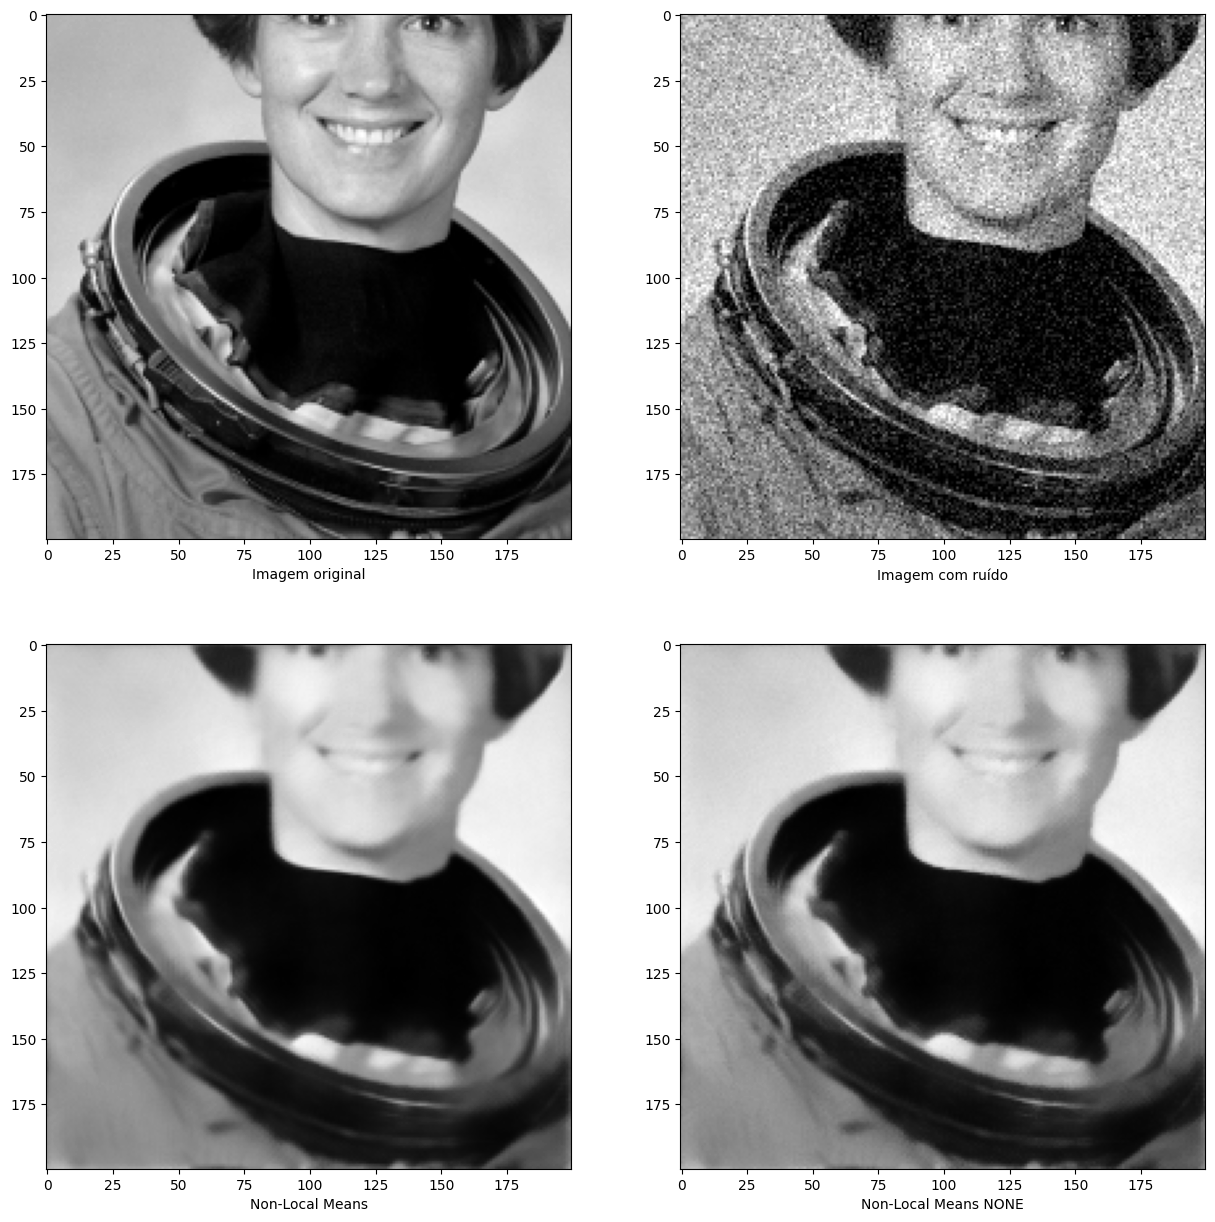

,Noise,Nlmeans,NONE Nlmeans
PSNR,20.550370,23.280931,23.461855
SSIM,0.447337,0.678876,0.685817
MSE,0.008810,0.003397,0.003277


In [78]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

plt.subplot(2, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(2, 2, 2)
plt.xlabel('Imagem com ruído')
plt.imshow(im_nse)

plt.subplot(2, 2, 3)
plt.xlabel('Non-Local Means')
plt.imshow(im_fil1)

plt.subplot(2, 2, 4)
plt.xlabel('Non-Local Means NONE')
plt.imshow(im_fil2)
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

im_noise_psnr = psnr(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_ssim = ssim(im, im_nse, data_range=im_nse.max() - im_nse.min())
im_noise_mse  = mse(im, im_nse)

im_nlm_psnr   = psnr(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_ssim   = ssim(im, im_fil1, data_range=im_fil1.max() - im_fil1.min())
im_nlm_mse    = mse(im, im_fil1)

im_none_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_none_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_none_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', 'NONE Nlmeans'],
)

## Análise do algoritmo

### Imagens deslocadas

Durante a execução do algoritmo, a imagem ruídosa é deslocada varias vezes para então ser subtraida da imagem inicial. Isso é feito com o objetivo de calcular o peso simultaneamente para todos os pixels, ao invés de calcular o peso pixel a pixel como é feito no algoritmo original. 

A ideia do Non-Local Means UDLF é, baseado no peso calculado para cada pixel na imagem, gerar novas imagens deslocadas para que dessa forma seja possível gerar pesos melhores.

<Figure size 1500x1500 with 0 Axes>

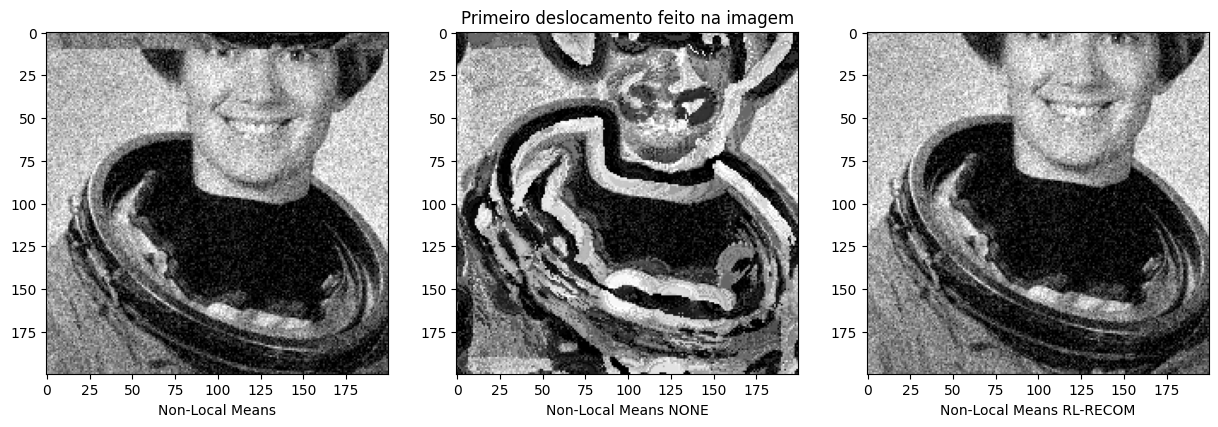

In [79]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 3, 1)
plt.xlabel('Non-Local Means')
plt.imshow(IMG_SHIFT_NLM)

plt.subplot(1, 3, 2)
plt.xlabel('Non-Local Means NONE')
plt.imshow(IMG_SHIFT_NONE)
plt.title('Primeiro deslocamento feito na imagem')

plt.subplot(1, 3, 3)
plt.xlabel(f'Non-Local Means {udl_method}')
plt.imshow(IMG_SHIFT_UDLF)

plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

In [88]:
(IMG_SHIFT_UDLF == im_nse).all()

True

Mesmo com a mudança de posição entre os pixels, o conjunto das diferenças dos pixels dentro de uma área de busca devem ser iguais. Uma simples visualização dos dados mostra que isso é verdadeiro.

### Diferença entre pixels

In [80]:
DIFF = np.array(DIFF)
DIFF_SORT = np.sort(DIFF)

DIFF_NONE = np.array(DIFF_NONE)
DIFF_NONE_SORT = np.sort(DIFF_NONE)

DIFF_UDLF = np.array(DIFF_UDLF)
DIFF_UDLF_SORT = np.sort(DIFF_UDLF)

print('DIFF == DIFF_NONE:', (DIFF_SORT == DIFF_NONE_SORT).all())
print('DIFF == DIFF_UDLF:', (DIFF_SORT == DIFF_UDLF_SORT).all())
print('DIFF_NONE == DIFF_UDLF:', (DIFF_NONE_SORT == DIFF_UDLF_SORT).all())

diffs = pd.DataFrame(
    {
        'Non-Local Means': DIFF_SORT,
        'Non-Local Means NONE': DIFF_NONE_SORT,
        'Non-Local Means UDLF': DIFF_UDLF_SORT,
    }
)

diffs.head(10)

DIFF == DIFF_NONE: True
DIFF == DIFF_UDLF: False
DIFF_NONE == DIFF_UDLF: False


,Non-Local Means,Non-Local Means NONE,Non-Local Means UDLF
0,0.000000e+00,0.000000e+00,0.000000e+00
1,2.381274e-09,2.381274e-09,2.381274e-09
2,3.496397e-09,3.496397e-09,3.496397e-09
3,1.688608e-06,1.688608e-06,1.688608e-06
4,1.112973e-05,1.112973e-05,1.112973e-05
5,1.679592e-05,1.679592e-05,1.679592e-05
6,2.800931e-05,2.800931e-05,2.800931e-05
7,2.945362e-05,2.945362e-05,2.945362e-05
8,4.607438e-05,4.607438e-05,4.607438e-05
9,4.984267e-05,4.984267e-05,4.984267e-05


### Diferença entre patches

O peso de cada pixel, porém, é dado pela fórmula:

$$
w(p, q) = e^{\frac{-d^2}{\tau^2}}
$$

onde

$$
d^2(B(p,f), B(q,f)) = \frac{1}{(2f+1)^2} \sum_{j \in B(0,f)} (u(p + j) - u(q + j))^2
$$

Ou seja, o peso está diretamente ligado aos valores dentro do patch. Uma forma de verificar isso é ver se a igualdade das diferenças se mantém após ser multiplicado pelo patch no domínio de Fourier.

In [81]:
DIFF_PATCH = np.array(DIFF_PATCH)
DIFF_PATCH_SORT = np.sort(DIFF_PATCH)

DIFF_PATCH_NONE = np.array(DIFF_PATCH_NONE)
DIFF_PATCH_NONE_SORT = np.sort(DIFF_PATCH_NONE)

DIFF_PATCH_UDLF = np.array(DIFF_PATCH_UDLF)
DIFF_PATCH_UDLF_SORT = np.sort(DIFF_PATCH_UDLF)

print('DIFF_PATCH == DIFF_PATCH_NONE:', (DIFF_PATCH_SORT == DIFF_PATCH_NONE_SORT).all())
print('DIFF_PATCH == DIFF_PATCH_UDLF:', (DIFF_PATCH_SORT == DIFF_PATCH_UDLF_SORT).all())
print('DIFF_PATCH_NONE == DIFF_PATCH_UDLF:', (DIFF_PATCH_NONE_SORT == DIFF_PATCH_UDLF_SORT).all())

diffs = pd.DataFrame(
    {
        'Non-Local Means': DIFF_PATCH_SORT,
        'Non-Local Means NONE': DIFF_PATCH_NONE_SORT,
        'Non-Local Means UDLF': DIFF_PATCH_UDLF_SORT,
    }
)

diffs.head(10)

DIFF_PATCH == DIFF_PATCH_NONE: False
DIFF_PATCH == DIFF_PATCH_UDLF: False
DIFF_PATCH_NONE == DIFF_PATCH_UDLF: False


,Non-Local Means,Non-Local Means NONE,Non-Local Means UDLF
0,0.000000,0.003328,0.000000
1,0.024694,0.013311,0.020037
2,0.025087,0.015131,0.020594
3,0.028041,0.016000,0.020598
4,0.029396,0.018667,0.022654
5,0.030020,0.019649,0.022826
6,0.030486,0.021194,0.023945
7,0.030981,0.021561,0.025112
8,0.032720,0.021722,0.025317
9,0.034499,0.023037,0.025630


É possível ver que a distância entre os patches é diferente das distâncias entre os pixels (mesmo que o conjunto de distâncias entre os pixels seja igual) uma vez que os pixels dentro dos patches não são os mesmos.

In [82]:
print('Soma DIFF_PATCH:', np.sum(DIFF_PATCH))
print('Soma DIFF_PATCH_NONE:', np.sum(DIFF_PATCH_NONE))
print('Soma DIFF_PATCH_UDLF:', np.sum(DIFF_PATCH_UDLF))
print('sum(DIFF_PATCH) == sum(DIFF_PATCH_UDLF):', np.sum(DIFF_PATCH) == np.sum(DIFF_PATCH_UDLF))

Soma DIFF_PATCH: 25.792458063879433
Soma DIFF_PATCH_NONE: 25.792458063879433
Soma DIFF_PATCH_UDLF: 26.01846694341809
sum(DIFF_PATCH) == sum(DIFF_PATCH_UDLF): False


### Peso dos pixels

In [83]:
WEIGHT = np.array(WEIGHT)
WEIGHT_SORT = np.sort(WEIGHT)

WEIGHT_NONE = np.array(WEIGHT_UDLF)
WEIGHT_NONE_SORT = np.sort(WEIGHT_NONE)

WEIGHT_UDLF = np.array(WEIGHT_UDLF)
WEIGHT_UDLF_SORT = np.sort(WEIGHT_UDLF)

print('WEIGHT == WEIGHT_NONE:', (WEIGHT_SORT == WEIGHT_NONE_SORT).all())
print('WEIGHT == WEIGHT_UDLF:', (WEIGHT_SORT == WEIGHT_UDLF_SORT).all())
print('WEIGHT_NONE == WEIGHT_UDLF:', (WEIGHT_NONE_SORT == WEIGHT_UDLF_SORT).all())
weights = pd.DataFrame(
    {
        'Non-Local Means': WEIGHT_SORT,
        'Non-Local Means NONE': WEIGHT_NONE_SORT,
        'Non-Local Means UDLF': WEIGHT_UDLF_SORT,
    }
)

weights.head(10)

WEIGHT == WEIGHT_NONE: False
WEIGHT == WEIGHT_UDLF: False
WEIGHT_NONE == WEIGHT_UDLF: True


,Non-Local Means,Non-Local Means NONE,Non-Local Means UDLF
0,9.665541e-07,0.000077,0.000077
1,3.241609e-06,0.000087,0.000087
2,3.969834e-06,0.000114,0.000114
3,6.171814e-06,0.000120,0.000120
4,7.767141e-06,0.000120,0.000120
5,1.198274e-05,0.000173,0.000173
6,1.769294e-05,0.000174,0.000174
7,1.934255e-05,0.000180,0.000180
8,1.947341e-05,0.000187,0.000187
9,2.342318e-05,0.000194,0.000194


In [84]:
print('Soma WEIGHT:', np.sum(WEIGHT))
print('Soma WEIGHT_NONE:', np.sum(WEIGHT_NONE))
print('Soma WEIGHT_UDLF:', np.sum(WEIGHT_UDLF))
print('sum(WEIGHT) == sum(WEIGHT_NONE):', np.sum(WEIGHT) == np.sum(WEIGHT_NONE))
print('sum(WEIGHT) == sum(WEIGHT_UDLF):', np.sum(WEIGHT) == np.sum(WEIGHT_UDLF))
print('sum(WEIGHT_NONE) == sum(WEIGHT_UDLF):', np.sum(WEIGHT_NONE) == np.sum(WEIGHT_UDLF))

Soma WEIGHT: 24.148050834136427
Soma WEIGHT_NONE: 30.44134630086186
Soma WEIGHT_UDLF: 30.44134630086186
sum(WEIGHT) == sum(WEIGHT_NONE): False
sum(WEIGHT) == sum(WEIGHT_UDLF): False
sum(WEIGHT_NONE) == sum(WEIGHT_UDLF): True


Text(0, 0.5, 'Pesos')

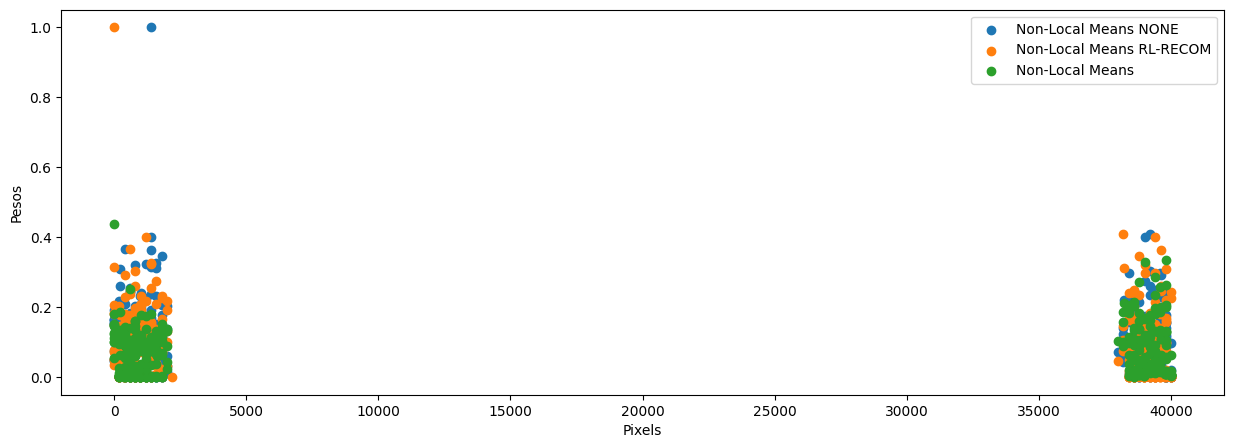

In [85]:
WEIGHT_ID = np.array(WEIGHT_ID)
WEIGHT_SORT_BY_ID = WEIGHT[WEIGHT_ID.argsort()]
WEIGHT_ID_SORT = np.sort(WEIGHT_ID)

WEIGHT_ID_NONE = np.array(WEIGHT_ID_NONE)
WEIGHT_NONE_SORT_BY_ID = WEIGHT_NONE[WEIGHT_ID_NONE.argsort()]
WEIGHT_ID_NONE_SORT = np.sort(WEIGHT_ID_NONE)

WEIGHT_ID_UDLF = np.array(WEIGHT_ID_UDLF)
WEIGHT_UDLF_SORT_BY_ID = WEIGHT_UDLF[WEIGHT_ID_UDLF.argsort()]
WEIGHT_ID_UDLF_SORT = np.sort(WEIGHT_ID_UDLF)


none_plot = plt.scatter(WEIGHT_ID_NONE_SORT, WEIGHT_NONE_SORT_BY_ID, label = 'Non-Local Means NONE')
udlf_plot = plt.scatter(WEIGHT_ID_UDLF_SORT, WEIGHT_UDLF_SORT_BY_ID, label = f'Non-Local Means {udl_method}')
nlm_plot  = plt.scatter(WEIGHT_ID_SORT, WEIGHT_SORT_BY_ID, label = 'Non-Local Means')
plt.legend(handles = [none_plot, udlf_plot, nlm_plot])
plt.xlabel('Pixels')
plt.ylabel('Pesos')


# Porque NONE é melhor que outros métodos?

A próxima seção se preocupa em tentar responder porque a distância euclideana (UDLF NONE) é geralmente melhor que outras distâncias geradas através de aprendizado supervisionado por métodos como (LHRR, CPRR e RL-RECOM)

## Hipótese 1

A distância euclideana é a que melhor representa imagens quando estas são muito pequenas (no caso do NLM as imagens comparadas são os patches que tem dimensão de 3x3 e 5x5 no geral)